In [ ]:
import re
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer
import evaluate

from tqdm import tqdm
tqdm.pandas()

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (17,7)
# plt.rcParams['font.size'] = 18

df = pd.read_csv('data/dataset.csv')
df


/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


,human,LLM
0,The 2013 film 12 Years a Slave proved that sla...,"""12 Years a Slave,"" directed by Steve McQueen,..."
1,Social Media Examiner’s (2021) video on social...,Effective change leadership plays a pivotal ro...
2,The world has been shattered by Russia’s attac...,**Analyzing the Headline: A Comparative Study ...
3,Charles Schwab is a for-profit Corporation who...,**Essay on the Business Form and Distinctive F...
4,The work of a clinical or medical office worke...,"In the discussion of career choices, a great d..."
...,...,...
2995,"NSFW LANGUAGE. Like. Lots of it.\n""Hey asshole...",Ella had always been the quiet shadow of Winte...
2996,"""Oh God, is it Gang Day again already?"" asked ...","I stepped into the dimly lit convention hall, ..."
2997,"I held on, slowly falling, looking up at the t...",You hang to life by a literal thread—suspended...
2998,"**Prolgue: Landfall**\n""Damn this fog and damn...",Years had passed since the zombies had overrun...


In [2]:
wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def clean(text):
    text = text.lower()
    text = re.sub('[^a-z A-Z 0-9-]+', '', text)
    text = " ".join([wnl.lemmatize(word, pos=penn2morphy(tag)) for word, tag in pos_tag(text.split()) if word not in stopwords.words('english')])
    
    return text

df['human_clean'] = df['human'].progress_apply(clean)
df['LLM_clean'] = df['LLM'].progress_apply(clean)

df['human_list'] = df['human_clean'].str.split()
df['LLM_list'] = df['LLM_clean'].str.split()

df

100%|██████████| 3000/3000 [02:31<00:00, 19.78it/s]


,human,LLM,human_clean,LLM_clean,human_list,LLM_list
0,The 2013 film 12 Years a Slave proved that sla...,"""12 Years a Slave,"" directed by Steve McQueen,...",2013 film 12 year slave prove slavery worldwid...,12 year slave direct steve mcqueen poignant ex...,"[2013, film, 12, year, slave, prove, slavery, ...","[12, year, slave, direct, steve, mcqueen, poig..."
1,Social Media Examiner’s (2021) video on social...,Effective change leadership plays a pivotal ro...,social medium examiner 2021 video social mediu...,effective change leadership play pivotal role ...,"[social, medium, examiner, 2021, video, social...","[effective, change, leadership, play, pivotal,..."
2,The world has been shattered by Russia’s attac...,**Analyzing the Headline: A Comparative Study ...,world shatter russias attack ukraine past day ...,analyze headline comparative study new york ti...,"[world, shatter, russias, attack, ukraine, pas...","[analyze, headline, comparative, study, new, y..."
3,Charles Schwab is a for-profit Corporation who...,**Essay on the Business Form and Distinctive F...,charles schwab for-profit corporation whose ma...,essay business form distinctive feature charle...,"[charles, schwab, for-profit, corporation, who...","[essay, business, form, distinctive, feature, ..."
4,The work of a clinical or medical office worke...,"In the discussion of career choices, a great d...",work clinical medical office worker characteri...,discussion career choice great deal focus ofte...,"[work, clinical, medical, office, worker, char...","[discussion, career, choice, great, deal, focu..."
...,...,...,...,...,...,...
2995,"NSFW LANGUAGE. Like. Lots of it.\n""Hey asshole...",Ella had always been the quiet shadow of Winte...,nsfw language like lot ithey asshole say step ...,ella always quiet shadow winterfield high book...,"[nsfw, language, like, lot, ithey, asshole, sa...","[ella, always, quiet, shadow, winterfield, hig..."
2996,"""Oh God, is it Gang Day again already?"" asked ...","I stepped into the dimly lit convention hall, ...",oh god gang day already ask mimi hadnt heard d...,step dimly lit convention hall first-ever sanc...,"[oh, god, gang, day, already, ask, mimi, hadnt...","[step, dimly, lit, convention, hall, first-eve..."
2997,"I held on, slowly falling, looking up at the t...",You hang to life by a literal thread—suspended...,hold slowly fall look thread hand slowly grow ...,hang life literal threadsuspended chasm finger...,"[hold, slowly, fall, look, thread, hand, slowl...","[hang, life, literal, threadsuspended, chasm, ..."
2998,"**Prolgue: Landfall**\n""Damn this fog and damn...",Years had passed since the zombies had overrun...,prolgue landfalldamn fog damn weather curse sh...,year pass since zombie overrun world devastate...,"[prolgue, landfalldamn, fog, damn, weather, cu...","[year, pass, since, zombie, overrun, world, de..."


In [3]:
df['human_len'] = df['human'].str.len()
df['LLM_len'] = df['LLM'].str.len()

word_count = lambda x: len(x.split())
df['human_word_cnt'] = df['human'].apply(word_count)
df['LLM_word_cnt'] = df['LLM'].apply(word_count)

mean_word_len = lambda x: np.mean([len(word) for word in x.split()])
df['human_word_len'] = df['human'].apply(mean_word_len)
df['LLM_word_len'] = df['LLM'].apply(mean_word_len)

mean_sent_len = lambda x: np.mean([len(sent) for sent in tokenize.sent_tokenize(x)])
df['human_sent_len'] = df['human'].apply(mean_sent_len)
df['LLM_sent_len'] = df['LLM'].apply(mean_sent_len)

unique_word_count = lambda x: len(set(x))
df['human_unique_word_cnt'] = df['human_list'].apply(unique_word_count)
df['LLM_unique_word_cnt'] = df['LLM_list'].apply(unique_word_count)

df

,human,LLM,human_clean,LLM_clean,human_list,LLM_list,human_len,LLM_len,human_word_cnt,LLM_word_cnt,human_word_len,LLM_word_len,human_sent_len,LLM_sent_len,human_unique_word_cnt,LLM_unique_word_cnt
0,The 2013 film 12 Years a Slave proved that sla...,"""12 Years a Slave,"" directed by Steve McQueen,...",2013 film 12 year slave prove slavery worldwid...,12 year slave direct steve mcqueen poignant ex...,"[2013, film, 12, year, slave, prove, slavery, ...","[12, year, slave, direct, steve, mcqueen, poig...",3855,2555,617,378,5.249595,5.751323,127.533333,169.133333,214,166
1,Social Media Examiner’s (2021) video on social...,Effective change leadership plays a pivotal ro...,social medium examiner 2021 video social mediu...,effective change leadership play pivotal role ...,"[social, medium, examiner, 2021, video, social...","[effective, change, leadership, play, pivotal,...",2058,2767,315,372,5.536508,6.430108,127.687500,161.588235,135,173
2,The world has been shattered by Russia’s attac...,**Analyzing the Headline: A Comparative Study ...,world shatter russias attack ukraine past day ...,analyze headline comparative study new york ti...,"[world, shatter, russias, attack, ukraine, pas...","[analyze, headline, comparative, study, new, y...",1784,3700,290,528,5.155172,5.996212,147.750000,166.954545,110,215
3,Charles Schwab is a for-profit Corporation who...,**Essay on the Business Form and Distinctive F...,charles schwab for-profit corporation whose ma...,essay business form distinctive feature charle...,"[charles, schwab, for-profit, corporation, who...","[essay, business, form, distinctive, feature, ...",2126,4681,324,622,5.564815,6.511254,131.937500,172.074074,110,270
4,The work of a clinical or medical office worke...,"In the discussion of career choices, a great d...",work clinical medical office worker characteri...,discussion career choice great deal focus ofte...,"[work, clinical, medical, office, worker, char...","[discussion, career, choice, great, deal, focu...",2314,2476,395,348,4.860759,6.100575,127.611111,189.384615,155,137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,"NSFW LANGUAGE. Like. Lots of it.\n""Hey asshole...",Ella had always been the quiet shadow of Winte...,nsfw language like lot ithey asshole say step ...,ella always quiet shadow winterfield high book...,"[nsfw, language, like, lot, ithey, asshole, sa...","[ella, always, quiet, shadow, winterfield, hig...",3068,3770,604,636,4.081126,4.902516,60.380000,60.540984,204,268
2996,"""Oh God, is it Gang Day again already?"" asked ...","I stepped into the dimly lit convention hall, ...",oh god gang day already ask mimi hadnt heard d...,step dimly lit convention hall first-ever sanc...,"[oh, god, gang, day, already, ask, mimi, hadnt...","[step, dimly, lit, convention, hall, first-eve...",1395,1671,241,257,4.792531,5.486381,72.473684,118.071429,126,147
2997,"I held on, slowly falling, looking up at the t...",You hang to life by a literal thread—suspended...,hold slowly fall look thread hand slowly grow ...,hang life literal threadsuspended chasm finger...,"[hold, slowly, fall, look, thread, hand, slowl...","[hang, life, literal, threadsuspended, chasm, ...",764,637,138,99,4.543478,5.434343,84.000000,69.777778,53,55
2998,"**Prolgue: Landfall**\n""Damn this fog and damn...",Years had passed since the zombies had overrun...,prolgue landfalldamn fog damn weather curse sh...,year pass since zombie overrun world devastate...,"[prolgue, landfalldamn, fog, damn, weather, cu...","[year, pass, since, zombie, overrun, world, de...",4122,4664,731,767,4.640219,5.066493,186.409091,124.756757,294,347


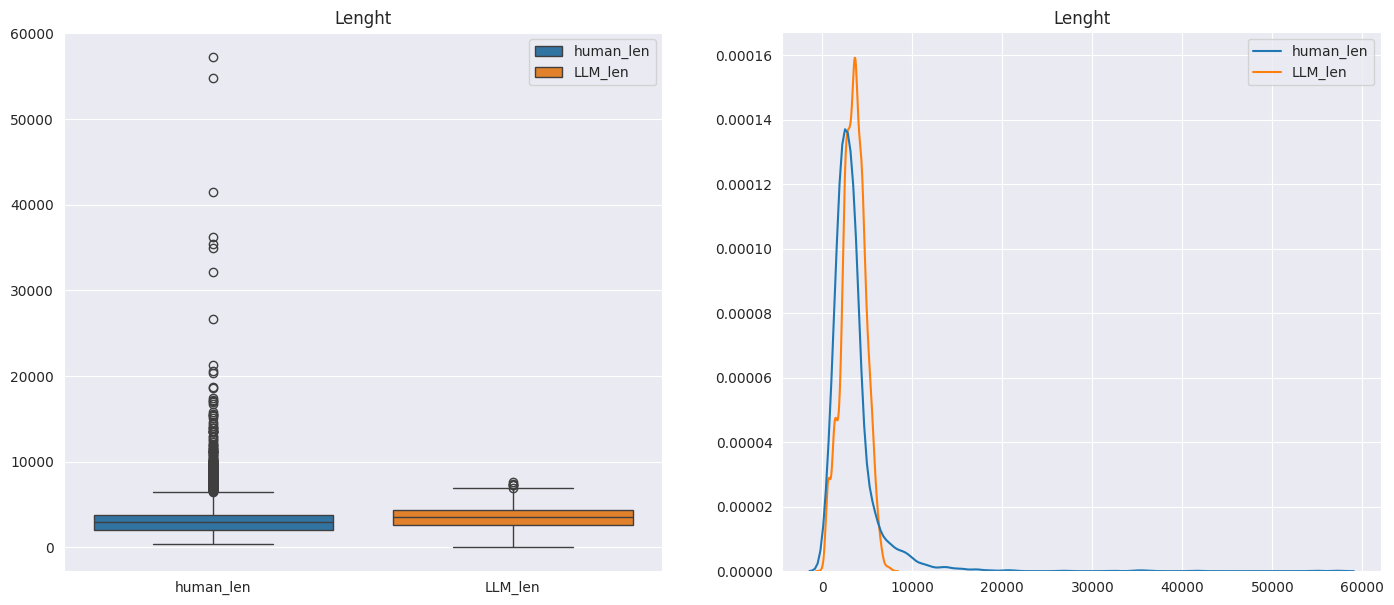

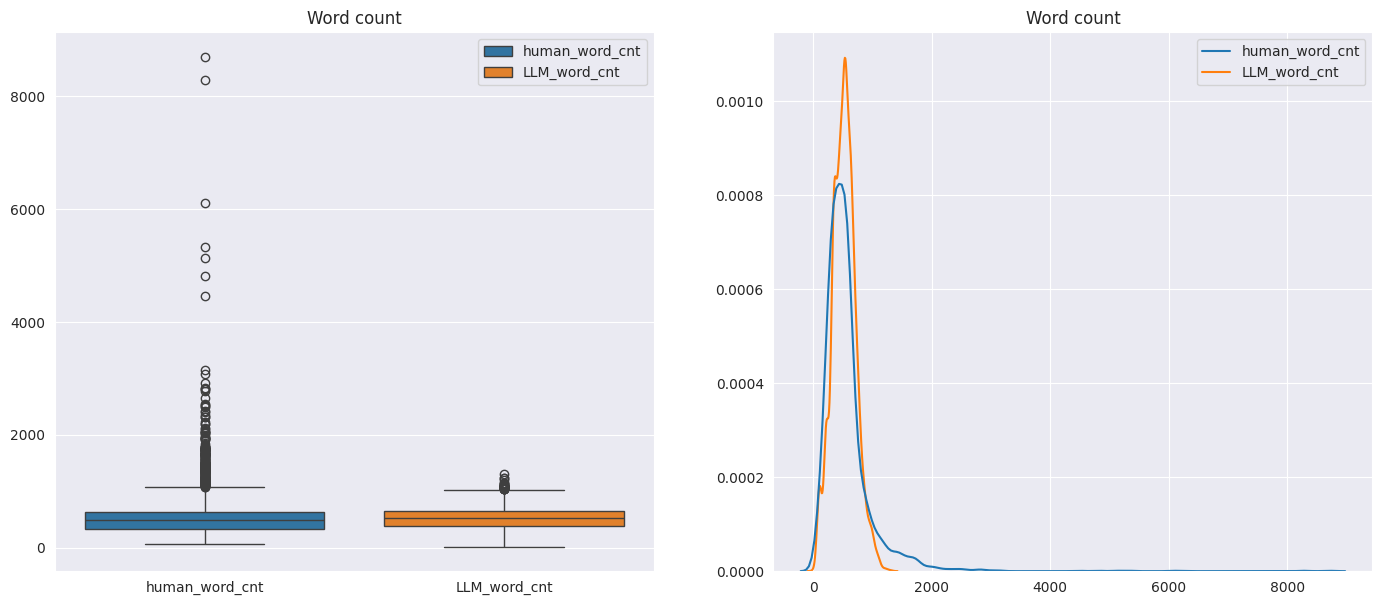

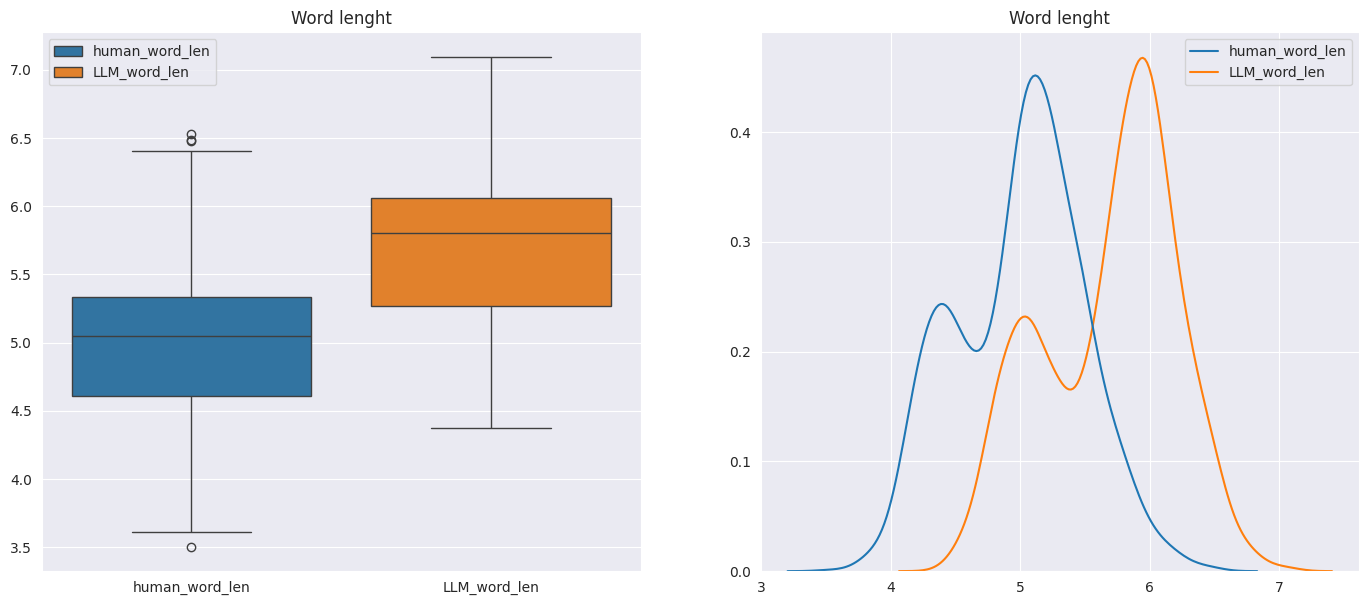

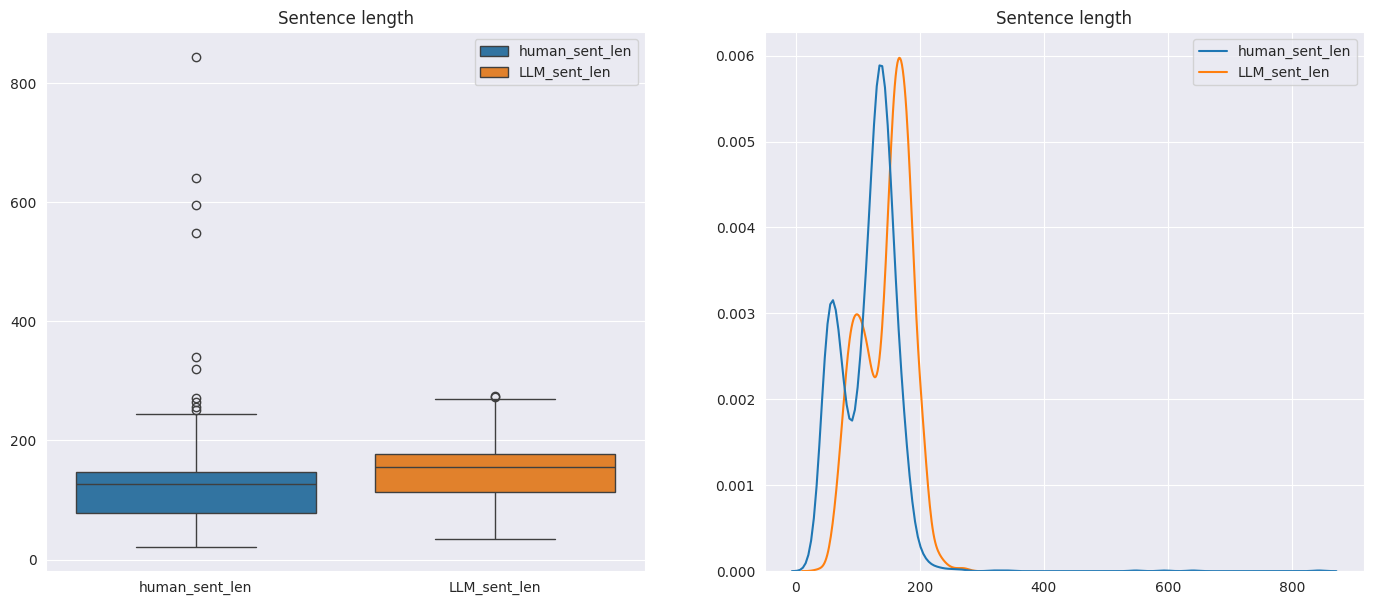

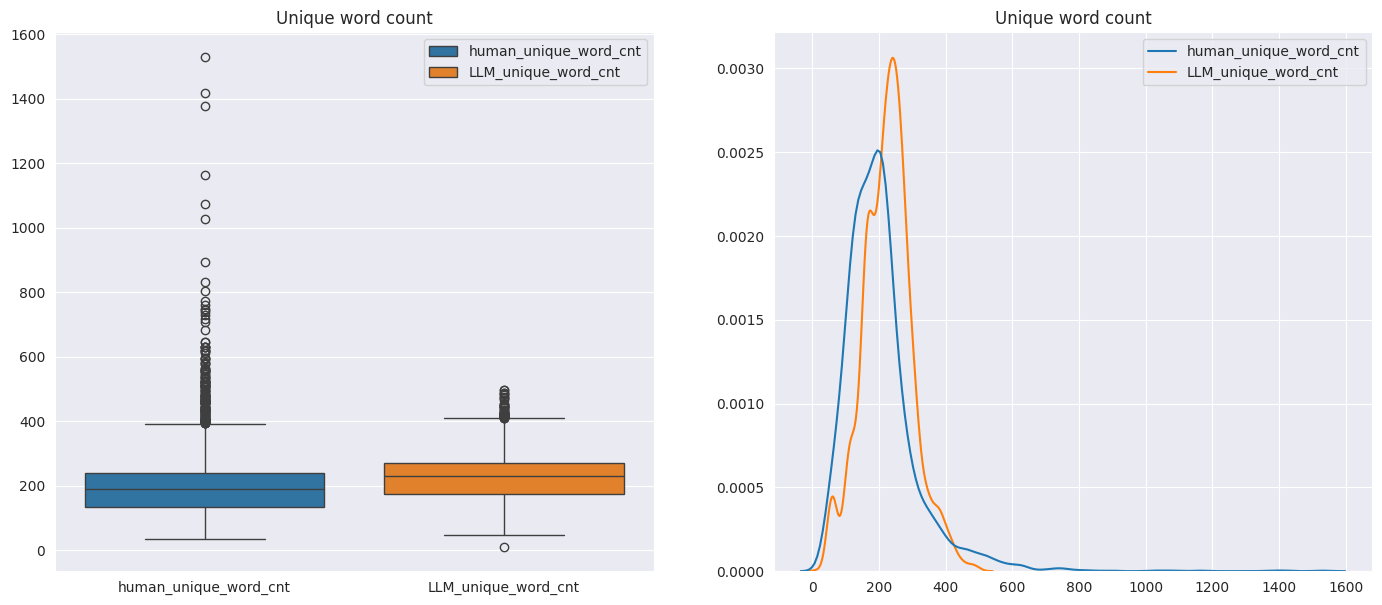

In [4]:
def visualize(df, cols, label):
    
    print()

    plt.subplot(1,2,1)
    plt.title(label)
    sns.boxplot(data=df[cols])
    plt.legend(cols)
    
    plt.subplot(1,2,2)
    plt.title(label)
    sns.kdeplot(df[cols])
    plt.xlabel('')
    plt.ylabel('')
    
    plt.show()

visualize(df, cols=['human_len', 'LLM_len'], label='Lenght')
visualize(df, cols=['human_word_cnt', 'LLM_word_cnt'], label='Word count')
visualize(df, cols=['human_word_len', 'LLM_word_len'], label='Word lenght')
visualize(df, cols=['human_sent_len', 'LLM_sent_len'], label='Sentence length')
visualize(df, cols=['human_unique_word_cnt', 'LLM_unique_word_cnt'], label='Unique word count')

In [5]:
df.describe()

,human_len,LLM_len,human_word_cnt,LLM_word_cnt,human_word_len,LLM_word_len,human_sent_len,LLM_sent_len,human_unique_word_cnt,LLM_unique_word_cnt
count,3000.000000,3000.000000,3000.00000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,3436.965000,3491.447000,566.99900,520.589000,4.998794,5.694191,117.365659,146.534006,205.119667,226.974333
std,2967.573558,1278.549035,452.86963,194.802302,0.494766,0.512770,46.336953,39.715753,112.945997,74.474710
min,376.000000,85.000000,62.00000,16.000000,3.504065,4.375000,21.687500,33.882353,34.000000,11.000000
25%,2028.750000,2637.000000,330.00000,379.000000,4.608885,5.266223,78.687500,112.919402,135.000000,175.000000
50%,2923.000000,3549.000000,487.00000,526.000000,5.050897,5.800630,126.415720,155.707780,190.000000,230.000000
75%,3812.500000,4370.000000,624.25000,640.000000,5.335313,6.058676,146.388462,176.400000,238.000000,269.000000
max,57256.000000,7644.000000,8704.00000,1304.000000,6.528926,7.095679,844.000000,274.916667,1530.000000,496.000000


In [6]:
human_corpus = df['human_list'].sum()
LLM_corpus = df['LLM_list'].sum()

In [7]:
from collections import Counter

human_common = Counter(human_corpus).most_common(10)
print(human_common)

LLM_common = Counter(LLM_corpus).most_common(10)
print(LLM_common)

[('say', 8637), ('one', 4652), ('would', 4377), ('make', 3540), ('people', 3400), ('company', 3222), ('use', 3221), ('year', 3191), ('time', 3077), ('also', 2824)]
[('also', 4080), ('market', 3619), ('could', 3168), ('new', 2880), ('like', 2755), ('company', 2425), ('global', 2390), ('financial', 2311), ('one', 2269), ('significant', 2251)]


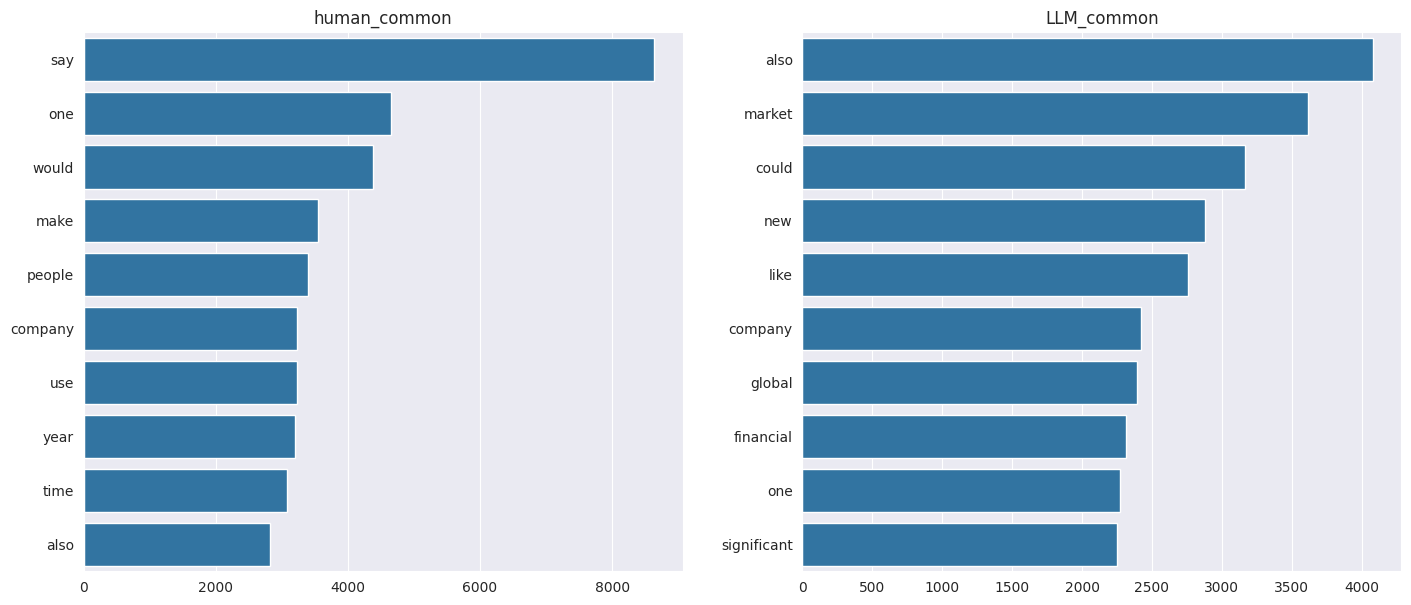

In [8]:
plt.subplot(1,2,1)
words = []
freq = []
for word, count in human_common:
    words.append(word)
    freq.append(count)
plt.title('human_common')
sns.barplot(x=freq, y=words)

plt.subplot(1,2,2)
words = []
freq = []
for word, count in LLM_common:
    words.append(word)
    freq.append(count)
plt.title('LLM_common')
sns.barplot(x=freq, y=words)

plt.show()

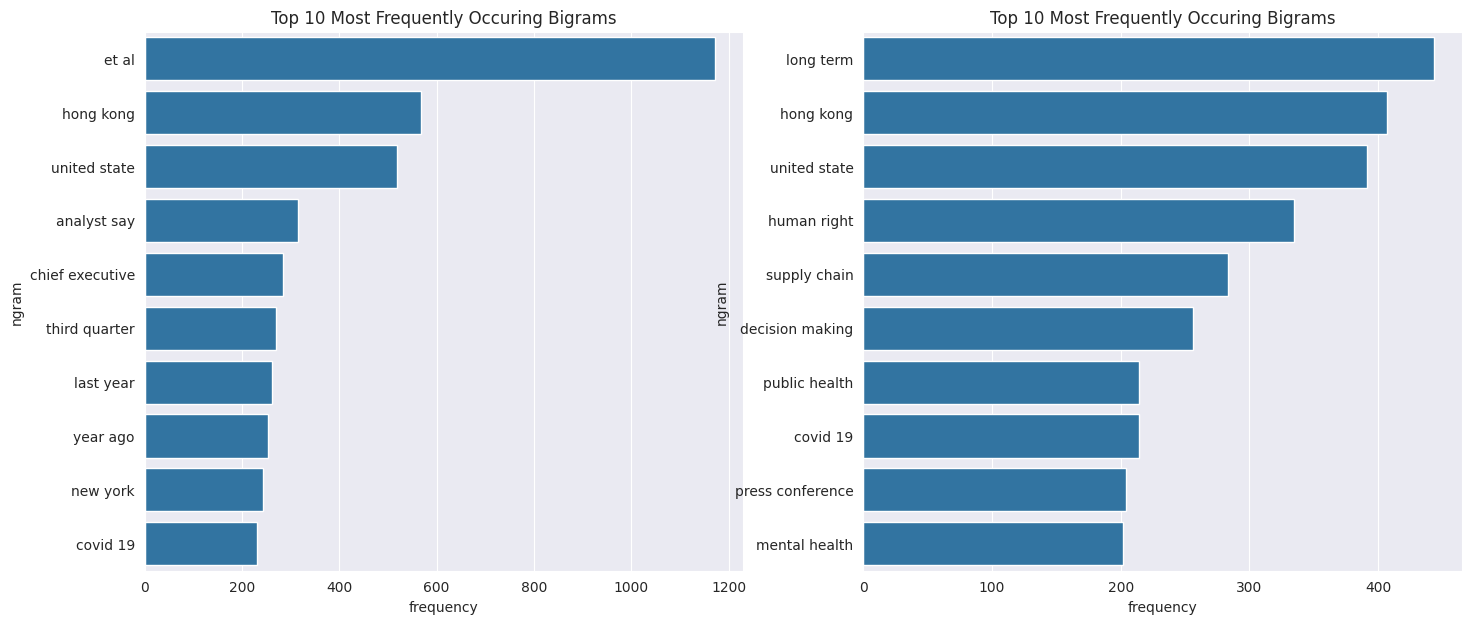

In [9]:
plt.subplot(1,2,1)
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df['human_clean'])
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')

plt.subplot(1,2,2)
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df['LLM_clean'])
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

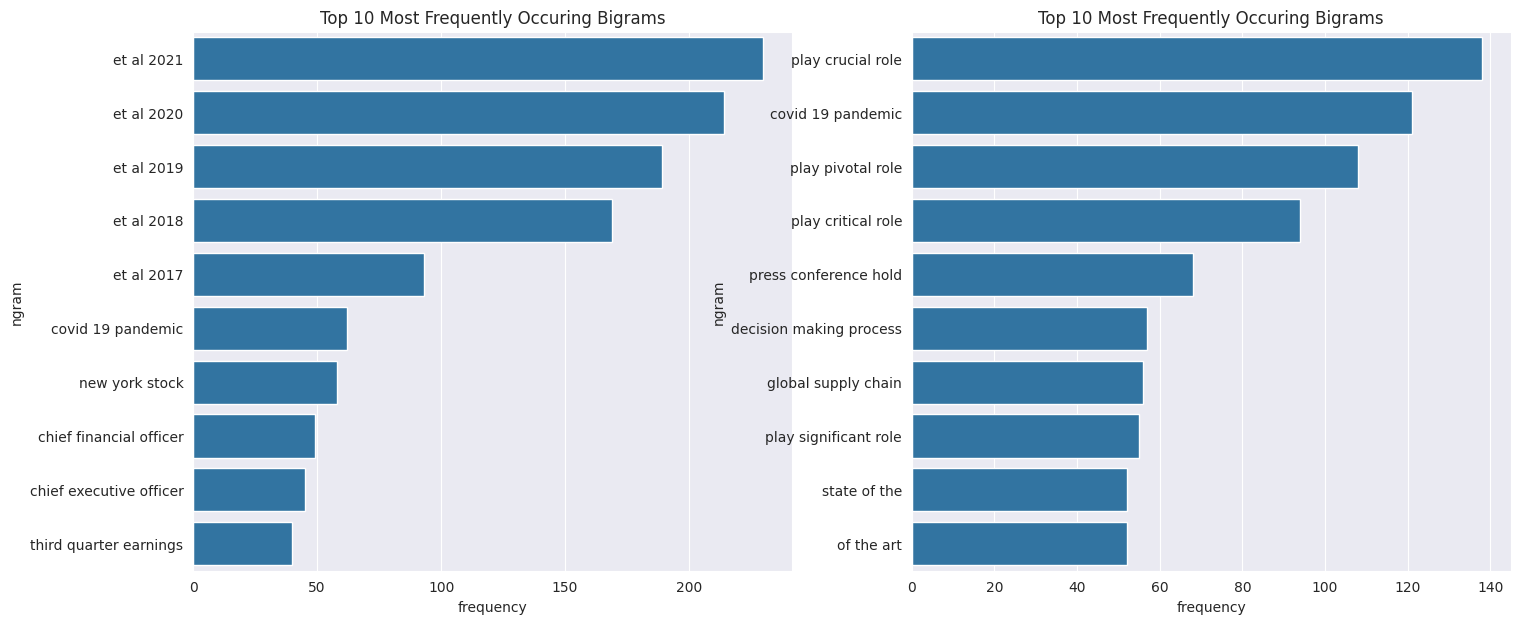

In [10]:
plt.subplot(1,2,1)
cv = CountVectorizer(ngram_range=(3,3))
trigrams = cv.fit_transform(df['human_clean'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')

plt.subplot(1,2,2)
cv = CountVectorizer(ngram_range=(3,3))
trigrams = cv.fit_transform(df['LLM_clean'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

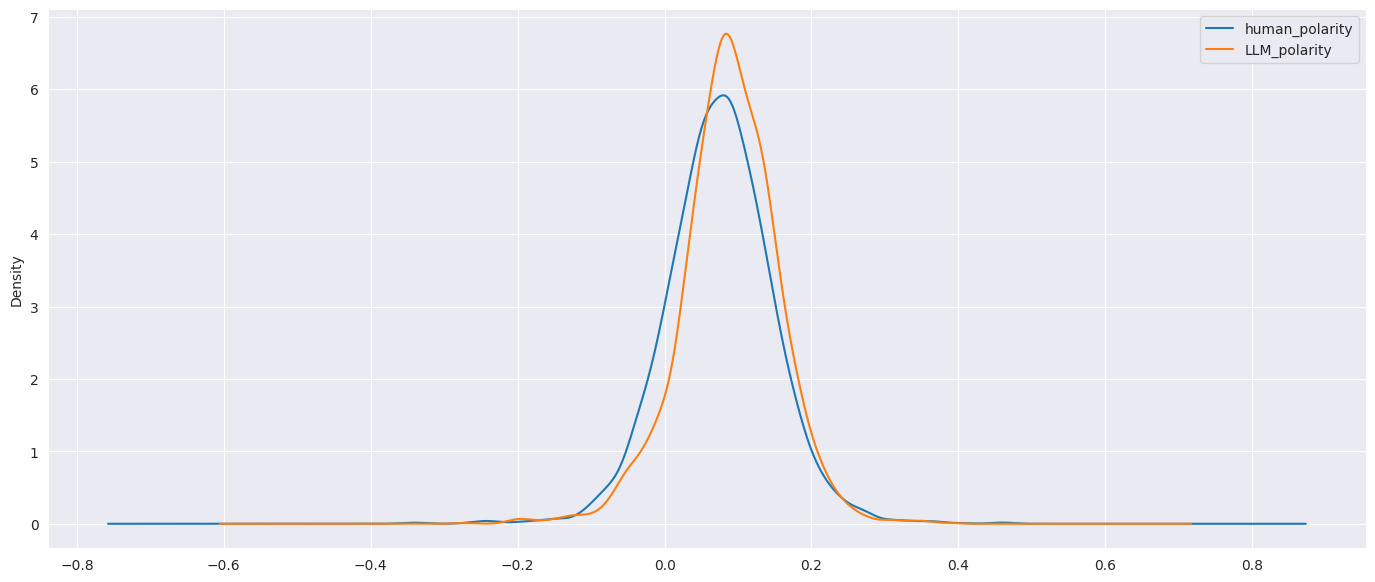

In [11]:
from textblob import TextBlob

def polarity(text):
    return TextBlob(text).sentiment.polarity

df['human_polarity'] = df['human'].apply(polarity)
df['LLM_polarity'] = df['LLM'].apply(polarity)

# plt.subplot(1,2,1)
df[['human_polarity', 'LLM_polarity']].plot.kde()
# plt.subplot(1,2,2)
# df[''].hist()
plt.show()

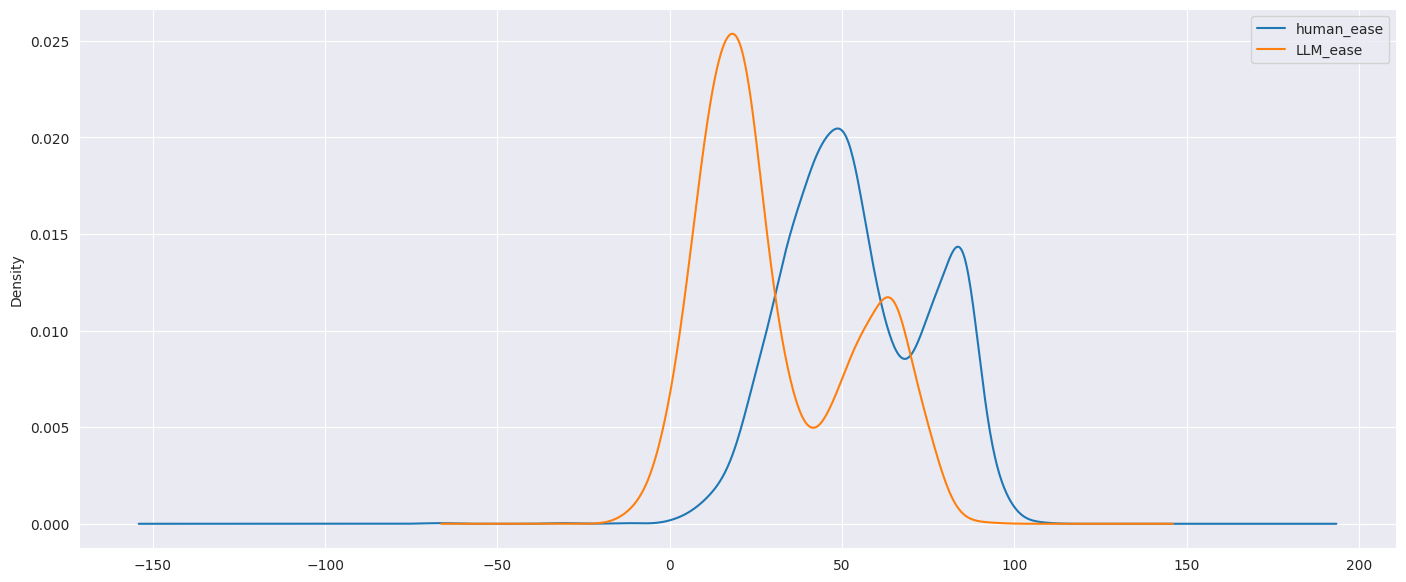

In [12]:
from textstat import flesch_reading_ease

df['human_ease'] = df['human'].apply(flesch_reading_ease)
df['LLM_ease'] = df['LLM'].apply(flesch_reading_ease)
df[['human_ease', 'LLM_ease']].plot.kde()
# plt.subplot(1,2,2)
# df[''].hist()
plt.show()

In [ ]:
rouge = evaluate.load('rouge')
results = rouge.compute(predictions=df['human_clean'], references=df['LLM_clean'])
results

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'rouge1': 0.1888242799600383,
 'rouge2': 0.024246314271184115,
 'rougeL': 0.08246772943850592,
 'rougeLsum': 0.0824467183665061}

In [14]:
bleu = evaluate.load("bleu")
results = bleu.compute(predictions=df['human_clean'], references=df['LLM_clean'])
results

{'bleu': 0.013476762082644573,
 'precisions': [0.19444980168878975,
  0.023524377113440218,
  0.004878403807370028,
  0.0014782192801273152],
 'brevity_penalty': 1.0,
 'length_ratio': 1.0081737592212368,
 'translation_length': 954056,
 'reference_length': 946321}

In [4]:
rouge = evaluate.load('rouge')
results = rouge.compute(predictions=df['human'], references=df['LLM'])
results

{'rouge1': 0.3407956379889926,
 'rouge2': 0.05862414195781386,
 'rougeL': 0.14295155886904137,
 'rougeLsum': 0.29649711656862643}

In [5]:
bleu = evaluate.load("bleu")
results = bleu.compute(predictions=df['human'], references=df['LLM'])
results

{'bleu': 0.03239691501568955,
 'precisions': [0.3468904480984441,
  0.06806410560337717,
  0.01232728857101168,
  0.003784744622663558],
 'brevity_penalty': 1.0,
 'length_ratio': 1.0963648205138463,
 'translation_length': 1972937,
 'reference_length': 1799526}

In [17]:
bertscore = evaluate.load("bertscore")
bertscore_results = bertscore.compute(predictions=df['human'], references=df['LLM'], lang="en")
print('precision', np.mean(bertscore_results['precision']))
print('recall', np.mean(bertscore_results['recall']))
print('f1', np.mean(bertscore_results['f1']))

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


precision 0.8266249127388
recall 0.8281174489458402
f1 0.827335516234239


In [18]:
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cdist

sbert_model = SentenceTransformer("all-MiniLM-L6-v2")
human_emb = sbert_model.encode(df['human'])
LLM_emb = sbert_model.encode(df['LLM'])

# Compute cosine distances
cosine_distances = cdist(human_emb, LLM_emb, metric="cosine")

# Extract diagonal (assuming pairwise comparison, one-to-one)
diagonal_distances = np.diag(cosine_distances)

# Compute mean cosine distance
mean_cosine_distance = np.mean(diagonal_distances)

# Compute mean cosine similarity
mean_cosine_similarity = 1 - mean_cosine_distance
print("Mean Cosine Similarity:", mean_cosine_similarity)

Mean Cosine Similarity: 0.6253123929670128


In [17]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import T5ForConditionalGeneration, T5Tokenizer
from datasets import Dataset as HFDataset
from tqdm import tqdm
from rouge_score import rouge_scorer
from torch.utils.tensorboard import SummaryWriter
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sentence_transformers import SentenceTransformer, util
from bert_score import score as bert_score

# Initialize TensorBoard
writer = SummaryWriter("runs/t5_finetune")

tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

dataset = HFDataset.from_pandas(df[['human', 'LLM']])

# Sentence Transformer for cosine similarity
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

class TextDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=512):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get LLM-generated and human text
        llm_text = self.dataset["LLM"][idx]
        human_text = self.dataset["human"][idx]

        # Tokenize inputs and targets
        input_encoding = tokenizer(llm_text, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt")
        target_encoding = tokenizer(human_text, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt")

        input_ids = input_encoding["input_ids"].squeeze()
        attention_mask = input_encoding["attention_mask"].squeeze()
        labels = target_encoding["input_ids"].squeeze()

        # T5 expects padding tokens (-100) instead of actual padding token ID
        labels[labels == tokenizer.pad_token_id] = -100  

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "human_text": human_text
        }

# Create train and eval datasets
train_size = int(0.9 * len(dataset))
train_dataset = TextDataset(dataset.select(range(train_size)), tokenizer)
eval_dataset = TextDataset(dataset.select(range(train_size, len(dataset))), tokenizer)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=8)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# ROUGE Scorer
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

# Evaluation function
def evaluate_model(model, eval_loader, tokenizer, device):
    model.eval()
    rouge_scores = {"rouge1": 0, "rouge2": 0, "rougeL": 0}
    total_bleu, total_cosine = 0, 0
    total_samples = 0
    all_references, all_candidates = [], []

    with torch.no_grad():
        for batch in tqdm(eval_loader, desc="Evaluating", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            human_texts = batch["human_text"]

            # Generate outputs
            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=512)
            generated_texts = [tokenizer.decode(o, skip_special_tokens=True) for o in outputs]

            # Compute ROUGE scores
            for gen_text, ref_text in zip(generated_texts, human_texts):
                scores = scorer.score(gen_text, ref_text)
                for key in rouge_scores:
                    rouge_scores[key] += scores[key].fmeasure

                # Compute BLEU score
                bleu_score = sentence_bleu([ref_text.split()], gen_text.split(), smoothing_function=SmoothingFunction().method1)
                total_bleu += bleu_score

                # Compute Cosine Similarity (SBERT)
                emb1 = sbert_model.encode(gen_text, convert_to_tensor=True)
                emb2 = sbert_model.encode(ref_text, convert_to_tensor=True)
                cosine_sim = util.pytorch_cos_sim(emb1, emb2).item()
                total_cosine += cosine_sim

                # Collect for BERTScore
                all_references.append(ref_text)
                all_candidates.append(gen_text)

            total_samples += len(human_texts)

    # Compute average scores
    for key in rouge_scores:
        rouge_scores[key] /= total_samples

    avg_bleu = total_bleu / total_samples
    avg_cosine = total_cosine / total_samples

    # Compute BERTScore
    P, R, F1 = bert_score(all_candidates, all_references, lang="en", model_type="bert-base-uncased")
    avg_bertscore = torch.mean(F1).item()

    print(f"Evaluation - ROUGE-1: {rouge_scores['rouge1']:.4f}, ROUGE-2: {rouge_scores['rouge2']:.4f}, ROUGE-L: {rouge_scores['rougeL']:.4f}")
    print(f"Evaluation - BLEU: {avg_bleu:.4f}, Cosine Similarity: {avg_cosine:.4f}, BERTScore F1: {avg_bertscore:.4f}")

    return rouge_scores, avg_bleu, avg_cosine, avg_bertscore

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for batch in progress_bar:
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items() if k != "human_text"}
        outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=batch["labels"])
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}: Average Training Loss = {avg_train_loss:.4f}")

    # Log training loss
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)

    # Evaluate model
    rouge_scores, avg_bleu, avg_cosine, avg_bertscore = evaluate_model(model, eval_loader, tokenizer, device)

    # Log evaluation scores
    writer.add_scalar("ROUGE-1", rouge_scores["rouge1"], epoch)
    writer.add_scalar("ROUGE-2", rouge_scores["rouge2"], epoch)
    writer.add_scalar("ROUGE-L", rouge_scores["rougeL"], epoch)
    writer.add_scalar("BLEU", avg_bleu, epoch)
    writer.add_scalar("Cosine Similarity", avg_cosine, epoch)
    writer.add_scalar("BERTScore", avg_bertscore, epoch)

# Save model
model.save_pretrained("./t5-finetuned")
tokenizer.save_pretrained("./t5-finetuned")
writer.close()
print("Fine-tuning complete! Model saved.")

Epoch 1/3: 100%|██████████| 338/338 [02:02<00:00,  2.76it/s, loss=4.39]


Epoch 1: Average Training Loss = 4.8090


Evaluation - ROUGE-1: 0.0668, ROUGE-2: 0.0072, ROUGE-L: 0.0479
Evaluation - BLEU: 0.0002, Cosine Similarity: 0.1958, BERTScore F1: 0.2793


Epoch 2/3: 100%|██████████| 338/338 [02:02<00:00,  2.77it/s, loss=4.54]


Epoch 2: Average Training Loss = 4.2930


Evaluation - ROUGE-1: 0.0844, ROUGE-2: 0.0079, ROUGE-L: 0.0614
Evaluation - BLEU: 0.0007, Cosine Similarity: 0.1882, BERTScore F1: 0.2824


Epoch 3/3: 100%|██████████| 338/338 [02:02<00:00,  2.76it/s, loss=4.2] 


Epoch 3: Average Training Loss = 4.2121


Evaluation - ROUGE-1: 0.0880, ROUGE-2: 0.0076, ROUGE-L: 0.0671
Evaluation - BLEU: 0.0008, Cosine Similarity: 0.1726, BERTScore F1: 0.2791
Fine-tuning complete! Model saved.
